<a href="https://colab.research.google.com/github/amirulal044/Machine-Learning-Sem7/blob/main/LinierRegressionGoogleColabYahoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving yahoo_saham.xlsx to yahoo_saham.xlsx


In [18]:
!pip install statsmodels openpyxl --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline


In [19]:
# ganti path jika kamu mount Google Drive
file_path = "yahoo_saham.xlsx"  # atau "/content/yahoo_data.xlsx" setelah upload

df = pd.read_excel(file_path, engine='openpyxl')
df.columns = df.columns.str.strip()  # trim whitespace

# Cari kolom Open/Close meski namanya 'Open (X)' atau 'Close (Y)'
open_col = [c for c in df.columns if 'open' in c.lower()][0]
# prefer close yang bukan 'adj' (Ambil Close biasa)
close_col = [c for c in df.columns if 'close' in c.lower() and 'adj' not in c.lower()][0]

# Rename untuk konsistensi
df = df.rename(columns={open_col: 'Open', close_col: 'Close'})

# Parse tanggal bila ada
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop NA pada variabel yang akan dipakai
df = df.dropna(subset=['Open', 'Close']).reset_index(drop=True)

print("Data shape:", df.shape)
df.head()


Data shape: (1258, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-04-28,33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,2023-04-27,33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,2023-04-26,33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,2023-04-25,33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,2023-04-24,33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [20]:
X = df['Open'].astype(float)
Y = df['Close'].astype(float)
n = len(X)

sumX = X.sum()
sumY = Y.sum()
sumX2 = (X**2).sum()
sumY2 = (Y**2).sum()
sumXY = (X*Y).sum()

b = (n*sumXY - sumX*sumY) / (n*sumX2 - sumX**2)
a = (sumY - b*sumX) / n

print("n:", n)
print("sumX:", sumX, "sumY:", sumY)
print("slope b (manual):", b)
print("intercept a (manual):", a)


n: 1258
sumX: 37231545.39 sumY: 37235996.989999995
slope b (manual): 0.9979381623240583
intercept a (manual): 64.56041575407991


In [21]:
Y_pred = a + b * X
residuals = Y - Y_pred

SSE = (residuals**2).sum()
SST = ((Y - Y.mean())**2).sum()
SSR = SST - SSE
R2_manual = 1 - SSE/SST

# korelasi r (manual formula)
r_num = n*sumXY - sumX*sumY
r_den = np.sqrt((n*sumX2 - sumX**2)*(n*sumY2 - sumY**2))
r_manual = r_num / r_den

print("SSE:", SSE)
print("SST:", SST)
print("R² (manual):", R2_manual)
print("r (manual):", r_manual)
print("r^2:", r_manual**2)


SSE: 97108619.91310105
SST: 20187176588.77116
R² (manual): 0.9951895888220883
r (manual): 0.9975918949260245
r^2: 0.9951895888220963


In [22]:
# sklearn
lr = LinearRegression()
lr.fit(X.values.reshape(-1,1), Y.values)
print("sklearn slope:", lr.coef_[0], "intercept:", lr.intercept_, "R2:", lr.score(X.values.reshape(-1,1), Y.values))

# statsmodels (memberi summary statistik lengkap)
X_sm = sm.add_constant(X)   # tambah konstanta a
model = sm.OLS(Y, X_sm).fit()
print(model.summary())  # menampilkan coef, SE, t-stat, p-values, R-squared, dll


sklearn slope: 0.9979381623240509 intercept: 64.56041575429845 R2: 0.9951895888220884
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.598e+05
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:53:54   Log-Likelihood:                -8863.8
No. Observations:                1258   AIC:                         1.773e+04
Df Residuals:                    1256   BIC:                         1.774e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [23]:
s = np.sqrt(SSE / (n - 2))
sum_x_dev_sq = ((X - X.mean())**2).sum()
SE_b = s / np.sqrt(sum_x_dev_sq)
t_stat = b / SE_b
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))

print("Residual std error s:", s)
print("SE(b):", SE_b)
print("t-stat (b):", t_stat)
print("p-value (two-sided):", p_value)


Residual std error s: 278.0571527322935
SE(b): 0.0019577038692571245
t-stat (b): 509.74929252335727
p-value (two-sided): 0.0


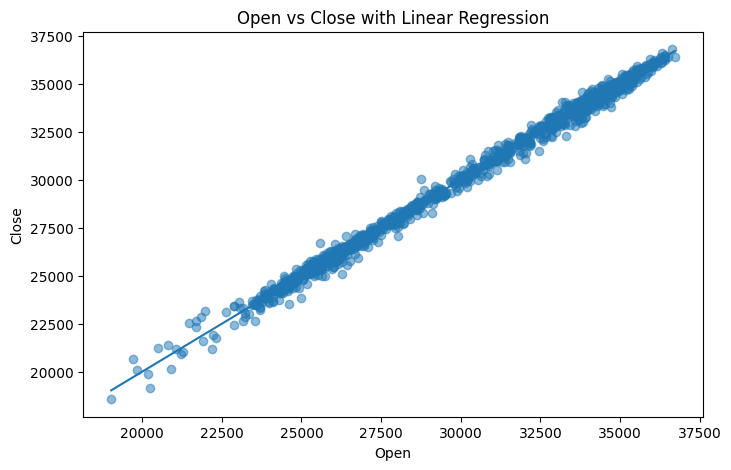

In [24]:
plt.figure(figsize=(8,5))
plt.scatter(X, Y, alpha=0.5)
# plot line sorted by X for visual yang halus
order = np.argsort(X)
plt.plot(X.values[order], Y_pred.values[order])
plt.xlabel("Open")
plt.ylabel("Close")
plt.title("Open vs Close with Linear Regression")
plt.show()


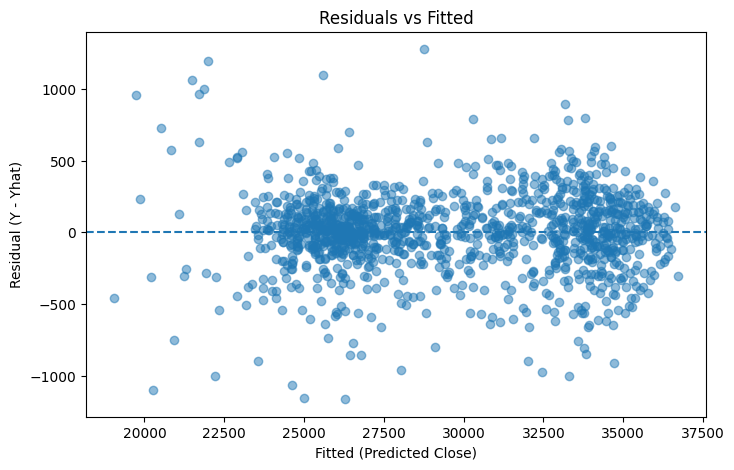

In [25]:
plt.figure(figsize=(8,5))
plt.scatter(Y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted (Predicted Close)")
plt.ylabel("Residual (Y - Yhat)")
plt.title("Residuals vs Fitted")
plt.show()


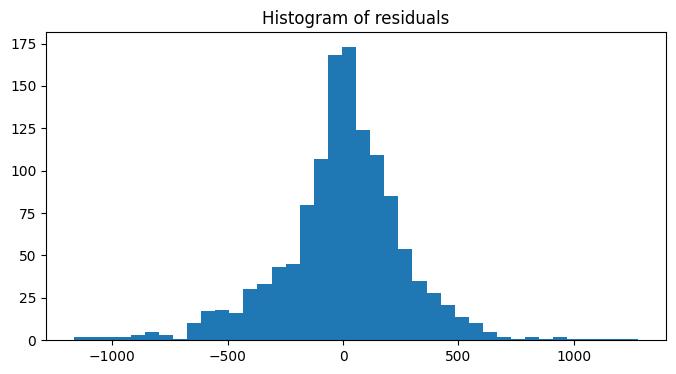

In [26]:
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=40)
plt.title("Histogram of residuals")
plt.show()


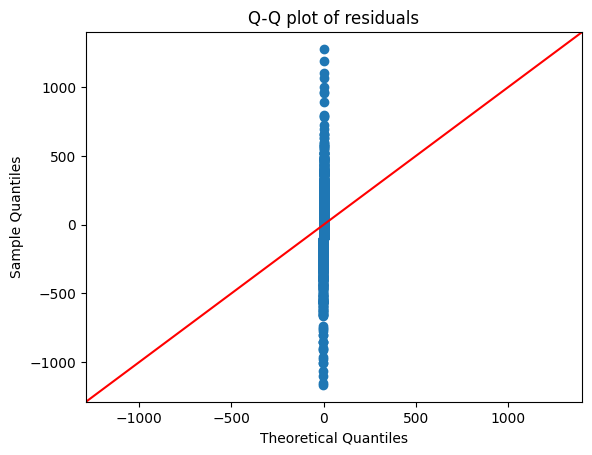

In [27]:
sm.qqplot(residuals, line='45')
plt.title("Q-Q plot of residuals")
plt.show()


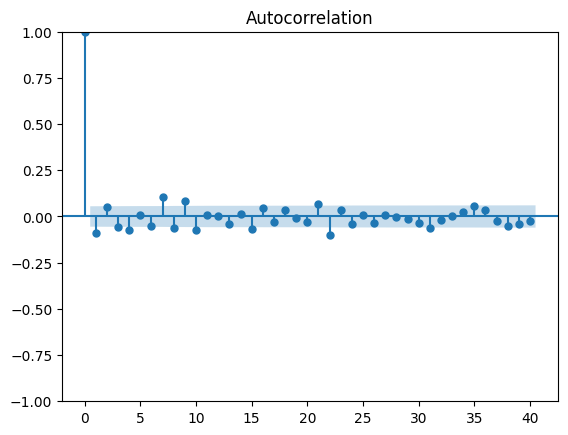

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.dropna(), lags=40)
plt.show()


In [29]:
# Nilai Open baru yang ingin kamu prediksi
X0 = 34000.0

# Buat DataFrame dengan kolom 'const' dan 'Open'
X0_df = pd.DataFrame({'const': [1], 'Open': [X0]})

# Prediksi dengan model
pred = model.get_prediction(X0_df)
pred_summary = pred.summary_frame(alpha=0.05)  # 95% confidence interval
print(pred_summary)


           mean    mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  33994.457935  11.653302   33971.595851   34017.320018  33448.471389   

   obs_ci_upper  
0   34540.44448  


In [31]:
df_out = df.copy()
df_out['Y_pred'] = Y_pred
df_out['residual'] = residuals
df_out.to_csv('yahoo_regression_results.csv', index=False)
# Jika ingin .xlsx
df_out.to_excel('yahoo_regression_results.xlsx', index=False)

# Jika di Colab, buat link download
from google.colab import files
files.download('yahoo_regression_results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>